# Experiments on KuHar Resampled to 30Hz

This notebook will perform basic experiments on the balanced KuHar dataset with the following steps:
1. Quick load train, test and validation CSV subsets from the balanced KuHar dataset using `PandasDatasetsIO` helper
2. Subclassing the `Dataset` interface using `PandasMultiModalDataset`
3. Apply the fourier transform on the dataset
4. Train and evaluate SVM, KNN and Random Forest classification models in both time and frequency domains

The experiments will evaluate the performance of SVM, KNN and RF models on the balanced KuHar dataset in both time and frequency domains.

## Common imports and definitions

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-09-11 19:01:17.889688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-11 19:01:17.889709: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading data
Change the path to use in other datasets

In [2]:
# Path for KuHar resampled to 30Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path_kuhar = Path("../data/views/KuHar/resampled_view_30Hz")
dataset_path_motionsense = Path("../data/views/MotionSense/resampled_view_30Hz")

Once paths is defined, we can load the CSV as pandas dataframes

In [3]:
# Kuhar/Motionsense dataframes
train_kuhar, validation_kuhar, test_kuhar = PandasDatasetsIO(dataset_path_kuhar).load()
train_motionsense, validation_motionsense, test_motionsense = PandasDatasetsIO(dataset_path_motionsense).load()

In [4]:
all_data_kuhar = pd.concat([train_kuhar, validation_kuhar, test_kuhar])
all_data_motionsense = pd.concat([train_motionsense, validation_motionsense, test_motionsense])

X = [0 for i in range(len(all_data_kuhar))]
all_data_kuhar['Dataset'] = X

X = [1 for i in range(len(all_data_motionsense))]
all_data_motionsense['Dataset'] = X

## Removing activities that don't exist in MotionSense and changing their codes.

In [6]:
activity_kuhar = {
        0: "Stand",
        1: "Sit",
        11: "Walk",
        14: "Run",
        15: "Stair-up",
        16: "Stair-down",
}

activity_motionsense = {
        3: "std",
        2: "sit",
        4: "wlk",
        5: "jog",
        1: "ups",
        0: "dws"
}

kh = list(activity_kuhar.keys())
ms = list(activity_motionsense.keys())
l = [k for k in range(6)]
kh

[0, 1, 11, 14, 15, 16]

In [7]:
all_data_kuhar = all_data_kuhar[all_data_kuhar['activity code'].isin(kh)]

In [8]:
all_data_kuhar['activity code'].unique()

array([ 0,  1, 11, 14, 15, 16])

In [9]:
for k in range(6):
    all_data_kuhar['activity code'] = all_data_kuhar['activity code'].replace(kh[k], k+6)

In [10]:
all_data_kuhar['activity code'].unique()

array([ 6,  7,  8,  9, 10, 11])

## Creating a Librep dataset from pandas dataframes

Change the features to use in other datasets

In [11]:
features_motionsense = list(all_data_motionsense.columns[1:-6]) + ['Dataset', 'activity code']
# all_data_motionsense.head()

In [12]:
features_kuhar = list(all_data_kuhar.columns[1:-10]) + ['Dataset', 'activity code']
# all_data_kuhar

In [13]:
# features_kuhar

In [14]:
X1 = np.array(all_data_kuhar[features_kuhar])
X2 = np.array(all_data_motionsense[features_motionsense])

In [15]:
all_data = pd.DataFrame(np.concatenate((X1, X2)), columns=list(features_kuhar))
all_data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-82,gyro-z-83,gyro-z-84,gyro-z-85,gyro-z-86,gyro-z-87,gyro-z-88,gyro-z-89,Dataset,activity code
0,0.003620,-0.023688,-0.002657,0.010371,-0.005858,0.010423,-0.019593,0.000303,0.045433,-0.004613,...,0.004720,0.003066,0.002235,0.002746,0.003216,0.002385,0.004016,0.003377,0.0,6.0
1,-0.005823,0.012494,-0.012503,-0.002116,0.025957,-0.012833,-0.025845,-0.011941,0.012807,0.004603,...,0.001823,0.001692,0.000443,-0.001092,-0.000615,-0.003112,0.002459,0.003056,0.0,6.0
2,-0.039278,0.003864,0.008927,-0.024887,0.022435,0.003431,-0.038931,0.003359,0.009394,-0.028853,...,0.002829,0.001145,0.004210,0.003512,0.003344,0.004968,0.003306,0.003442,0.0,6.0
3,-0.001728,-0.018312,0.013927,0.015426,0.007332,-0.012372,0.006893,-0.002433,0.012821,-0.010669,...,-0.001025,0.000604,-0.000815,-0.001659,0.000037,-0.001675,-0.002496,-0.001294,0.0,6.0
4,-0.022981,0.014871,-0.036310,0.033512,-0.016733,0.019930,-0.016637,0.007568,-0.002753,0.007763,...,0.003199,0.007891,0.003509,-0.000226,0.002749,0.003864,0.002099,0.004560,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6307,-0.257739,-0.387816,-0.173476,0.401424,0.062274,0.182838,0.316312,0.797721,0.122884,-0.211215,...,-0.419386,-0.537688,-0.142900,-0.064428,1.354706,1.892422,1.264995,-2.081829,1.0,5.0
6308,-0.417850,-0.813467,-1.772154,0.110662,0.612424,-0.210375,-3.099767,-1.809887,1.201129,1.294668,...,3.360833,2.770319,1.119818,-1.302019,-2.736272,-2.743174,-5.340605,-9.005032,1.0,5.0
6309,-0.319039,-0.012836,-0.030483,0.055985,-0.254981,0.211430,-0.041847,-0.099284,-0.506961,0.054123,...,0.218662,-0.496350,-0.307832,-0.091498,0.026900,-0.440731,-0.454998,-0.905865,1.0,5.0
6310,0.348365,0.525269,0.059976,-0.090873,-0.357481,-0.309874,-0.269182,-0.843015,0.002578,0.313414,...,0.660084,-0.148731,0.088839,-0.309311,0.312411,-0.292259,-0.482670,0.631022,1.0,5.0


In [16]:
features = features_kuhar[:-2]
# features

## t-SNE Transform

In [17]:
from sklearn.manifold import TSNE

tsne_model = TSNE(random_state=42)
tsne_df = tsne_model.fit_transform(all_data[features])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [18]:
tsne_df = pd.DataFrame(tsne_df, columns=["X", "Y"])
tsne_df
tsne_df["class"] = all_data['Dataset']

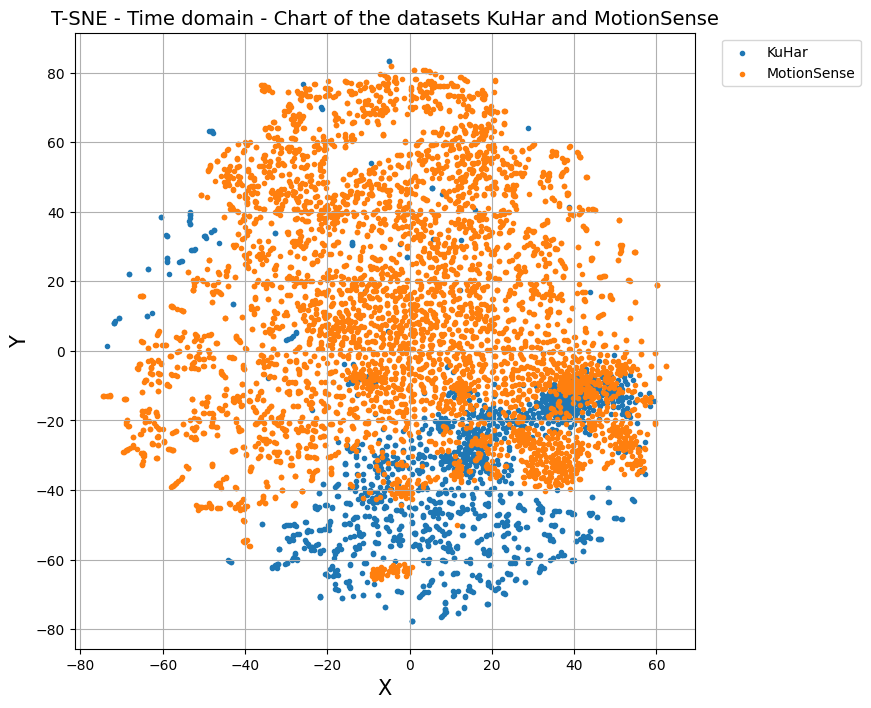

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15)
ax.set_title("T-SNE - Time domain - Chart of the datasets KuHar and MotionSense", fontsize=14)

labels = []
for c, ds in tsne_df.groupby(["class"]):
    ax.scatter(ds["X"], ds["Y"], marker='.')
    if c  == 0:
        labels.append('KuHar')
    else:
        labels.append('MotionSense')
#     else:
#         labels.append(f"{c}")
ax.legend(labels, bbox_to_anchor = (1.28, 1.))
ax.grid()
plt.show()

Lets show the datasets in the frequency domain and compare with the result above

## Creating a Librep dataset from pandas dataframes

Change the features to use in other datasets

In [20]:
# Kuhar and MotionSense features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
all_data_multimodal = PandasMultiModalDataset(
    all_data,
    feature_prefixes=features,
    label_columns="Dataset",
    as_array=True
)

## Fourier Transform

In [21]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [22]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

### Use FFT in the data

In [23]:
all_data_multimodal_fft = transformer(all_data_multimodal)
all_data_multimodal_fft.X

array([[3.13384994e-02, 1.68121633e-01, 9.05549650e-02, ...,
        5.92594004e-03, 1.10474894e-02, 7.03162882e-03],
       [2.30704315e-02, 1.23651598e-01, 6.28149230e-02, ...,
        8.26119084e-03, 3.20484735e-03, 5.24385686e-03],
       [7.81909007e-02, 7.24224293e-02, 1.34035957e-01, ...,
        1.17237633e-02, 8.03545237e-03, 2.37891069e-02],
       ...,
       [1.25378580e+00, 1.29129674e+00, 9.38914062e-01, ...,
        1.17296740e+00, 7.80122121e-01, 1.21739774e+00],
       [3.12722220e+00, 2.91728302e+00, 2.09904721e+00, ...,
        1.26141987e+00, 5.88594950e+00, 1.62984581e+00],
       [1.52514540e+00, 1.44493422e+00, 1.36297853e+00, ...,
        1.90046437e+00, 1.36809620e+00, 1.49000302e+00]])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


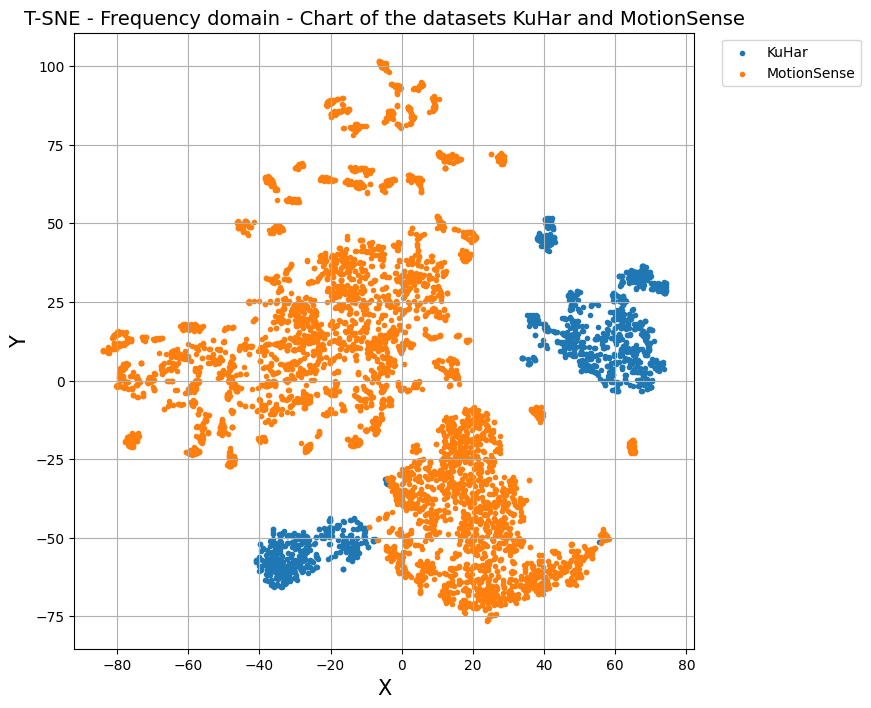

In [24]:
tsne_model = TSNE(random_state=42)
tsne_df = tsne_model.fit_transform(all_data_multimodal_fft.X)

tsne_df = pd.DataFrame(tsne_df, columns=["X", "Y"])
tsne_df
tsne_df["class"] = all_data_multimodal_fft.y

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15)
ax.set_title("T-SNE - Frequency domain - Chart of the datasets KuHar and MotionSense", fontsize=14)

labels = []
for c, ds in tsne_df.groupby(["class"]):
    ax.scatter(ds["X"], ds["Y"], marker='.')
    if c  == 0:
        labels.append('KuHar')
    else:
        labels.append('MotionSense')
#     else:
#         labels.append(f"{c}")
ax.legend(labels, bbox_to_anchor = (1.28, 1.))
ax.grid()
plt.show()

## Use t-SNE to show only the classes run and jogging 

In [25]:
def transformMultimodal(X):
    # Kuhar and MotionSense features to select
    features = [
        "accel-x",
        "accel-y",
        "accel-z",
        "gyro-x",
        "gyro-y",
        "gyro-z"
    ]

    # Creating the datasets

    # Train
    data_multimodal = PandasMultiModalDataset(
        X,
        feature_prefixes=features,
        label_columns="activity code",
        as_array=True
    )
    return data_multimodal

def tsne(data, num_classes, classes, features):

    X = data[data['activity code'].isin(num_classes)]
    X_new = transformMultimodal(X)

    fft_transform = FFT(centered = True)
    transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")
    data_multimodal_fft = transformer(X_new)
    
    tsne_model = TSNE(random_state=42)
    tsne_df = tsne_model.fit_transform(data_multimodal_fft.X)

    tsne_df = pd.DataFrame(tsne_df, columns=["X", "Y"])
    tsne_df
    tsne_df["class"] = data_multimodal_fft.y

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('X', fontsize=15)
    ax.set_ylabel('Y', fontsize=15)
    ax.set_title("T-SNE - Frequency domain - Chart of the datasets KuHar and MotionSense", fontsize=14)

    labels = []
    for c, ds in tsne_df.groupby(["class"]):
        ax.scatter(ds["X"], ds["Y"], marker='.')
        if c  == num_classes[0]:
            labels.append(classes[num_classes[0]])
        else:
            labels.append(classes[num_classes[1]])

    ax.legend(labels, bbox_to_anchor = (1.28, 1.))
    ax.grid()
    plt.show()

In [26]:
pares = [[0, 11], [1, 10], [2, 7], [3, 6], [4, 8], [5, 9]]

labels_ms = ['Downstairs', 'Upstairs', 'Sitting', 'Standing', 'Walking', 'Jogging']
labels_kh = ["Stand", "Sit", "Walk", "Run", "Stair-up", "Stair-down"]

classes = []
for c in labels_ms:
    classes.append(c + ' - MS')
for c in labels_kh:
    classes.append(c + ' - KH')
classes

['Downstairs - MS',
 'Upstairs - MS',
 'Sitting - MS',
 'Standing - MS',
 'Walking - MS',
 'Jogging - MS',
 'Stand - KH',
 'Sit - KH',
 'Walk - KH',
 'Run - KH',
 'Stair-up - KH',
 'Stair-down - KH']

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


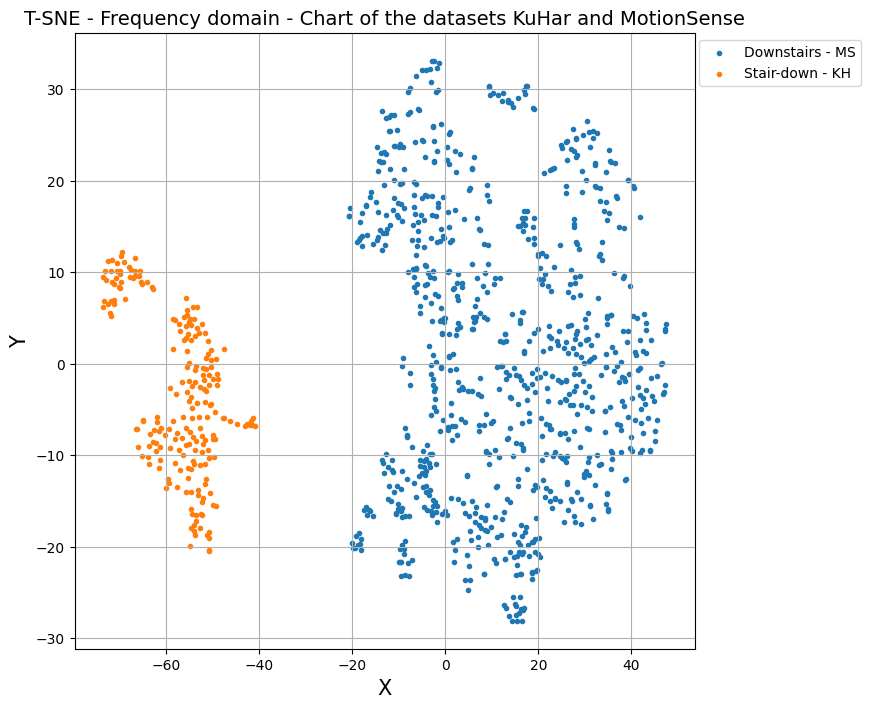

In [27]:
tsne(all_data, pares[0], classes, features)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


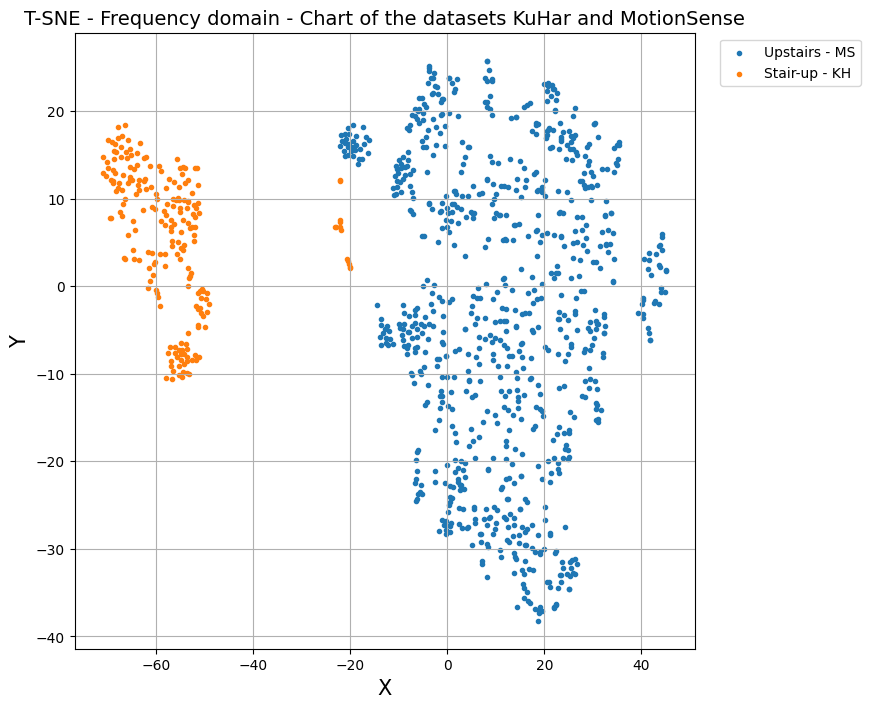

In [28]:
tsne(all_data, pares[1], classes, features)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


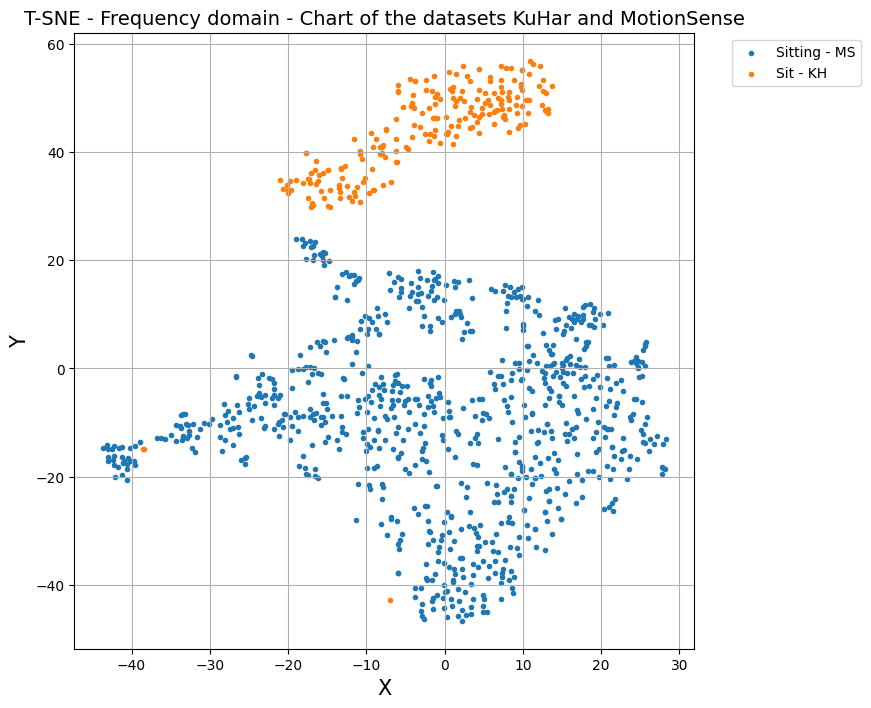

In [29]:
tsne(all_data, pares[2], classes, features)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


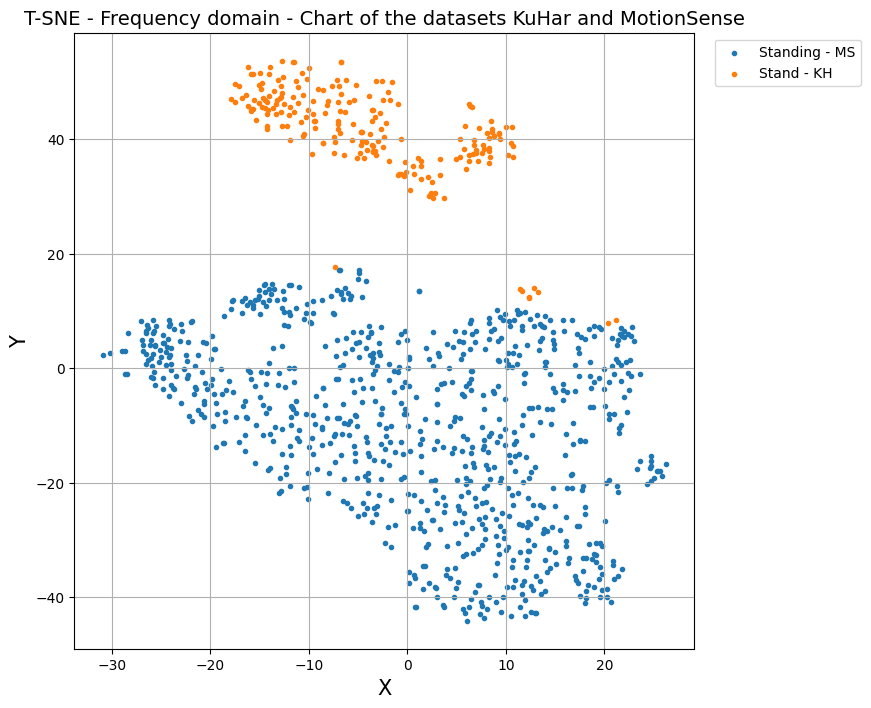

In [30]:
tsne(all_data, pares[3], classes, features)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


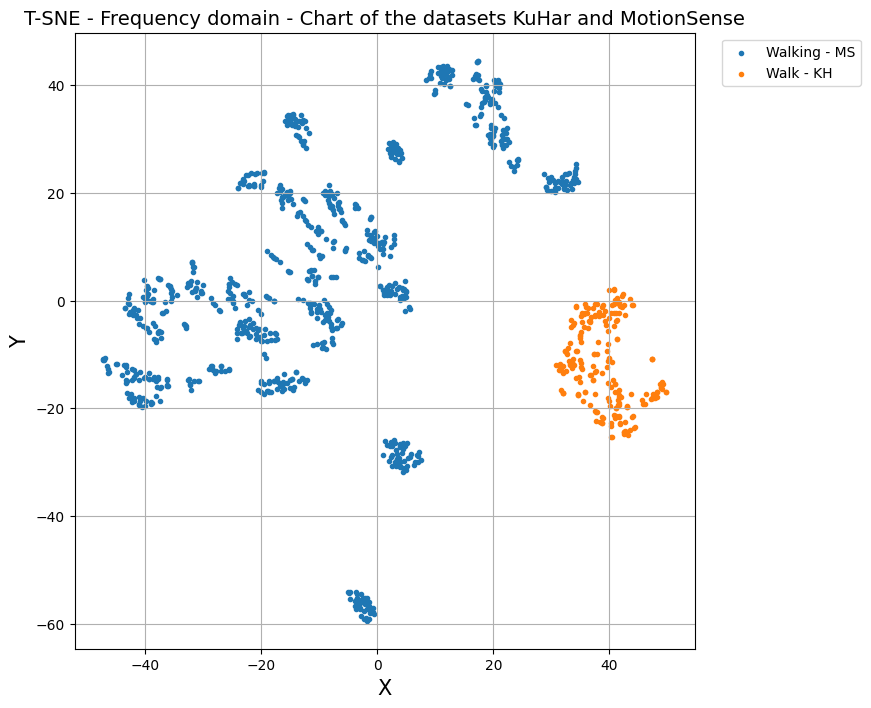

In [31]:
tsne(all_data, pares[4], classes, features)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


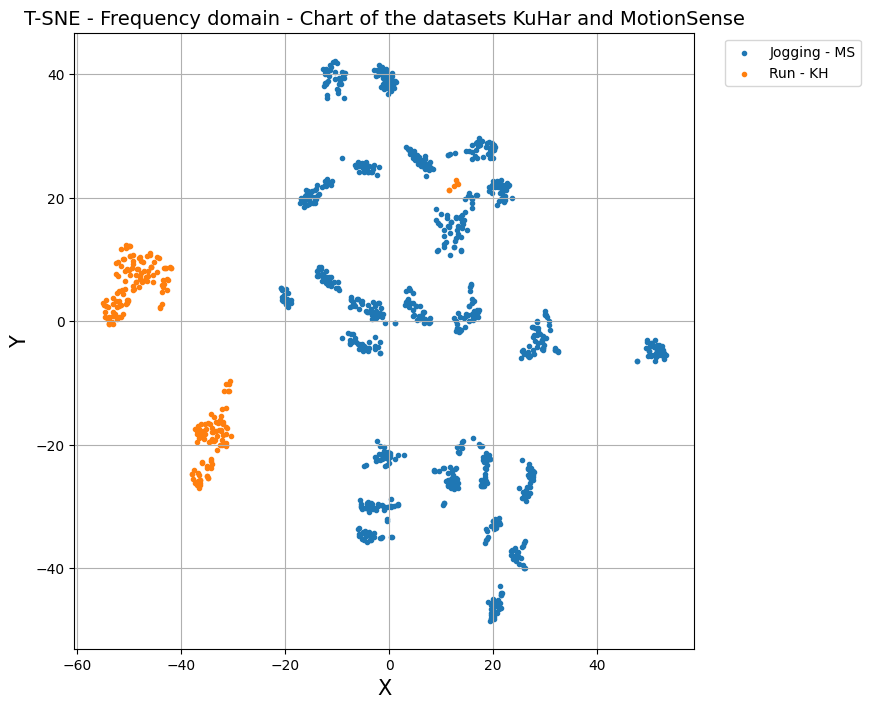

In [32]:
tsne(all_data, pares[5], classes, features)

## Train and evaluate Randon Forest

In [35]:
# from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
# from librep.estimators import RandomForestClassifier
# from librep.metrics.report import ClassificationReport
# import yaml

# reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
# experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

## Train and evaluate Lasso

In [36]:
# from sklearn.linear_model import Lasso

# reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
# experiment = SimpleTrainEvalWorkflow(estimator=Lasso, estimator_creation_kwags ={'alpha':0.1} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

# result = multi_run_experiment(combined_train_dset, test_dataset)
# print(yaml.dump(result, sort_keys=True, indent=4))

## Train and evaluate Support Vector Machine classifier

In [ ]:
# #from librep.estimators import SVC
# from sklearn.svm import SVC

# experiment = SimpleTrainEvalWorkflow(estimator=SVC, estimator_creation_kwags ={'C':3.0, 'kernel':"linear"} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

# result = multi_run_experiment(combined_train_dset, test_dataset)
# print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:
# result = multi_run_experiment(combined_train_dset_fft, test_dataset_fft)
# print(yaml.dump(result, sort_keys=True, indent=4))

## Train and evaluate K Neighbors Classifier classifier

In [ ]:
# #from librep.estimators import KNeighborsClassifier
# from sklearn.neighbors import KNeighborsClassifier

# experiment = SimpleTrainEvalWorkflow(estimator=KNeighborsClassifier, estimator_creation_kwags ={'n_neighbors' :1} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

# result = multi_run_experiment(combined_train_dset, test_dataset)
# print(yaml.dump(result, sort_keys=True, indent=4))

In [ ]:
# result = multi_run_experiment(combined_train_dset_fft, test_dataset_fft)
# print(yaml.dump(result, sort_keys=True, indent=4))